In [1]:
# use the .py script will be faster
import re 
import numpy as np
import obspy
from obspy import UTCDateTime
from ccfj import CC
from ccfj import GetStationPairs
from concurrent.futures import ThreadPoolExecutor
import os
import time
from geopy.distance import great_circle

In [2]:
Dir = '/mnt/d/Data/USArrayNoise/FJ-Validation/4Hz/DataDemo/' # dir that store the SAC data
dirs = os.listdir(Dir)
print(dirs)

['TA-P37A', 'TA-T38A', 'TA-U38A']


In [3]:
# Check if the data exists
def Checkdata(dirname):
    global year
    global day
    global Dir
    filename = os.path.join(Dir,dirname)
    filename = os.path.join(filename,dirname+'-'+year+'-'+day+'-BHZ.SAC')
    if os.path.exists(filename):
        return True
    return False

# Set the rules for reading data
# this will determined by the data files' distribution 
def Readdata(i):
    global year
    global day
    global Dir
    global npts
    global namelist
    global Fs
    global data
    global startend
    dirname = namelist[i]
    filename = os.path.join(Dir,dirname)
    filename = os.path.join(filename,dirname+'-'+year+'-'+day+'-BHZ.SAC')
    st = obspy.read(filename)
    st[0].detrend(type='constant')
    st[0].detrend("spline",order=3,dspline=400)
    if st[0].stats.npts>=npts:
        data[npts*i:npts*(i+1)] = st[0].data[0:npts]
        startend[i*2] = 0
        startend[i*2+1] = npts
    else:
        t0 = UTCDateTime(st[0].stats.starttime)
        idx0 = int((t0.second+t0.minute*60+t0.hour*60*60)*Fs)
        t1 = UTCDateTime(st[0].stats.endtime)
        idx1 = int((t1.second+t1.minute*60+t1.hour*60*60)*Fs)
        data[(npts*i+idx0):(npts*i+idx1)] = st[0].stats.station[0:(idx1-idx0)]
        startend[i*2] = idx0
        startend[i*2+1] = idx1

In [4]:
# Set Params
Fs = 4
npts = 60*60*24*Fs
nf = 1000
fstride = 3
nThreads = 20
fftlen = Fs*60*60
overlaprate = 0.9
nThreads = 20
f = np.arange(0,nf)*Fs/fftlen*fstride
outdir = 'output'
if not os.path.exists(outdir):
    os.mkdir(outdir)

In [5]:
start = time.time()
for y in range(2011,2012):
    for d in range(200,210): 
        year = str(y)
        day = "%03d"%d
        print("year"+year+" day"+day)
        namelist = []
        for dirname in dirs:
            if Checkdata(dirname):
                namelist.append(dirname)
        nsta = len(namelist)
        # at least two stations needs
        if nsta >1:
            start0 = time.time()
            data = np.zeros([npts*nsta],dtype = np.float32)
            startend = np.zeros([nsta*2],dtype = np.int32)
            # using multiThreads to read data
            # the maximum speed is limited by your harddriver
            pool = ThreadPoolExecutor(max_workers = nThreads)
            for i in range(nsta):
                pool.submit(Readdata,i)
            pool.shutdown()
            ## Generate a list for Station Paris 
            StationPairs = GetStationPairs(nsta)
            nPairs = int(len(StationPairs)/2)
            ## Crosscorrelation
            ncfs=CC(npts,nsta,nf,fftlen,StationPairs,startend,data,fstride=fstride,overlaprate=overlaprate,nThreads=nThreads)
            outname = os.path.join(outdir,year+'-'+day+'.npz')
            if os.path.exists(outname):
                os.remove(outname)
            np.savez(outname,ncfs=ncfs,StationPairs=StationPairs,stalist=namelist,f=f)
            print('time:',time.time()-start0,' seconds')

print(time.time()-start)

year2011 day200
time: 0.8194217681884766  seconds
year2011 day201
time: 0.3662731647491455  seconds
year2011 day202
time: 1.3693714141845703  seconds
year2011 day203
time: 1.1418943405151367  seconds
year2011 day204
time: 0.47299909591674805  seconds
year2011 day205
time: 0.3932626247406006  seconds
year2011 day206
time: 0.38094139099121094  seconds
year2011 day207
time: 0.5187513828277588  seconds
year2011 day208
time: 0.4269232749938965  seconds
year2011 day209
time: 0.36768674850463867  seconds
6.4945969581604


In [6]:
# Gather Saved data
stalistname = 'stations' # station list
stalist = []
#stalist = dir
lon = []
lat =[]
with open(stalistname,'r') as f:
    while True:
        tmp = f.readline()
        if tmp:
            stalist.append(tmp.split()[0])
            lon.append(float(tmp.split()[1]))
            lat.append(float(tmp.split()[2]))
        else:
            break
            
nsta = len(stalist)
print(stalist)
StationPairs = GetStationPairs(nsta)
nPairs = int(nsta*(nsta-1)/2)
ncfs = np.zeros([nPairs,nf],dtype=np.complex64)
count = np.zeros(nPairs)

## Read CCFs day by day
for y in range(2011,2012):
    for d in range(200,210):
        year = str(y)
        day = "%03d"%d
        print(year+'-'+day)
        outname = os.path.join(outdir,year+'-'+day+'.npz')
        if os.path.exists(outname):
            data = []
            data = np.load(outname)
            nsta0 = len(data["stalist"])
            id1 = []
            id2 = []
            for i in range(nPairs):
                st1 = stalist[StationPairs[2*i]]
                st2 = stalist[StationPairs[2*i+1]]
                i1 = np.where(data["stalist"]==st1)[0]
                i2 = np.where(data["stalist"]==st2)[0]
                if len(i1)*len(i2)>0:
                    #count[i] = count[i]+1
                    idx1 = min(i1[0],i2[0])
                    idx2 = max(i1[0],i2[0])
                    tmp = int(idx1*(2*nsta0-idx1-1)/2+idx2-idx1-1)
                    id1.append(i)
                    id2.append(tmp)
                    #ncfs[i,:] = ncfs[i,:] + data["ncfsr"][tmp,:]
            ncfs[id1,:] = ncfs[id1,:]+data["ncfs"][id2,:]
            count[id1] = count[id1]+1

ncfs1 = np.zeros(np.shape(ncfs),dtype=np.complex64)
for i in range(nPairs):
    if count[i]>0:
        ncfs1[i,:] = ncfs[i,:]/count[i] 

r = np.zeros(nPairs)
for i in range(len(r)):
    r[i] = great_circle((lat[StationPairs[i*2]],lon[StationPairs[i*2]]),(lat[StationPairs[i*2+1]],lon[StationPairs[i*2+1]])).km

indx = np.argsort(r)
r0  = r[indx]
ncfs0 = ncfs1[indx,:]
f = np.arange(0,nf)*Fs/fftlen*fstride
np.savez("summed.npz",ncfs= ncfs0,r = r0,f=f)

['TA-P37A', 'TA-T38A', 'TA-U38A']
2011-200
2011-201
2011-202
2011-203
2011-204
2011-205
2011-206
2011-207
2011-208
2011-209


In [7]:
ncfs0

array([[  3.29004340e-02+0.j        ,   4.13313210e-02+0.00028247j,
          5.21791838e-02-0.00284692j, ...,  -1.49744144e-02-0.01795287j,
          5.66498414e-02-0.00898781j,   2.38086227e-02+0.02888566j],
       [ -1.38528142e-02+0.j        ,  -1.44509776e-02+0.00510948j,
         -1.46061406e-02+0.00778322j, ...,   5.69596887e-05-0.01920998j,
          2.40481533e-02-0.00167279j,  -3.89997475e-02-0.01815356j],
       [  4.32900572e-03+0.j        ,   3.03474674e-03+0.00305914j,
          7.59844948e-03+0.00369409j, ...,   1.89875774e-02+0.03158651j,
          2.61425469e-02-0.02693715j,   4.01037149e-02+0.00504528j]], dtype=complex64)

(-500.0, 500.0)

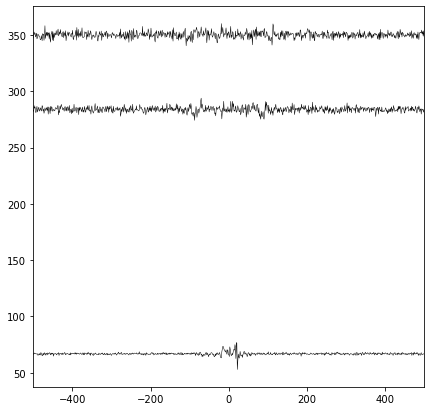

In [13]:
## plot
import matplotlib.pyplot as plt

    
dt = 1/np.max(f) 
t = (np.linspace(-len(f)/2,len(f)/2-1,len(f))+0.5)*dt

ncfst = np.zeros(np.shape(ncfs0))
for i in range(len(ncfs)):
    ncfst[i,:] = np.real(np.fft.fftshift(np.fft.ifft(ncfs0[i,:])))


fig,ax = plt.subplots(ncols=1,figsize=(7,7))


for i in range(0,len(r)):
    ax.plot(t,np.real(ncfst[i,:])/np.max(np.real(ncfst[i,:]))*10+r0[i],'k',linewidth=0.5)
ax.set_xlim([-500,500])

 